In [ ]:
"""
Created on Fri Mar 17 17:15:10 2023

@author: hoyeong
@Python: 3.9.16v

### GEE Part2 - Bitemporal Change detection ###
"""

#### Import Library

In [1]:

import rasterio
from scipy.stats import norm, gamma, f, chi2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import glob
import folium
import cd


#### Load Files

In [2]:
fp = glob.glob(r'A:/PYTHON/ChangeDetection/S1_GRD_4326/*.tif')
fp.sort()

im_list = []

for file in fp:
    '''Create im_list'''
    with rasterio.open(file) as src:
        raster_data = {
            'band_data': {'vv_band': src.read(1),
                          'vh_band': src.read(2)},
            'angle': src.read(3), # read(1) : VV | read(2): VH | read(3): Angle
            'meta': src.meta,
            'bounds': src.bounds,
            'name': src.name.split('/')[-1].split('.')[0]
        }
        im_list.append(raster_data)

# Check shape of im_list
'''
for i in range(len(im_list)):
    print(im_list[i]['band_data']['vv_band'].shape)
print('\n')
for i in range(len(im_list)):
    print(im_list[i]['band_data']['vh_band'].shape)
'''
# Match the shape of Images in im_list IF SHAPE DOESN'T MATCH
# im_list = cd.match(im_list)


(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)


(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 1856)
(1159, 185

#### Make a sub image(Subset)

In [3]:

aoi_sub = {"coordinates": [
          [
            [
              129.3352679337704,
              35.944751176829314
            ],
            [
              129.3352679337704,
              35.93625423648341
            ],
            [
              129.3574237991255,
              35.93625423648341
            ],
            [
              129.3574237991255,
              35.944751176829314
            ],
            [
              129.3352679337704,
              35.944751176829314
            ]
          ]
        ],
        "type": "Polygon"
      }

coordinates = aoi_sub['coordinates'][0]

min_lon = min(coord[0] for coord in coordinates)
max_lon = max(coord[0] for coord in coordinates)
min_lat = min(coord[1] for coord in coordinates)
max_lat = max(coord[1] for coord in coordinates)

im_list_sub = cd.subset_raster(fp, lon=(min_lon, max_lon),
                                   lat=(min_lat, max_lat))


#### Ratio Image (Using Sub images)

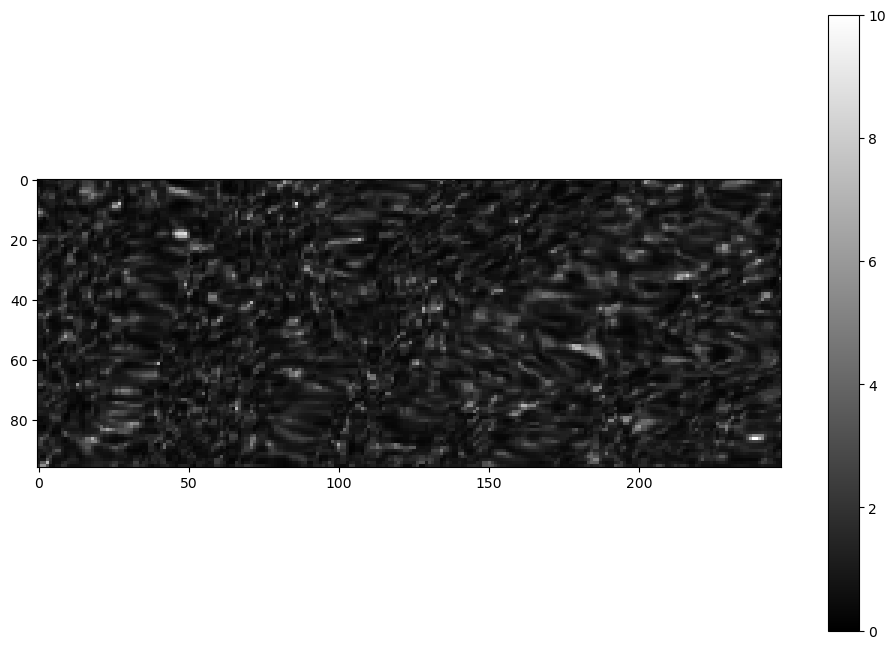

In [4]:

ratio_sub = np.divide(im_list_sub[0]['band_data']['vv_band'], 
                      im_list_sub[1]['band_data']['vv_band'])


plt.figure(figsize = (12, 8))
plt.imshow(ratio_sub, cmap='gray', vmin=0, vmax=10)
plt.colorbar()
plt.show()


#### Histogram

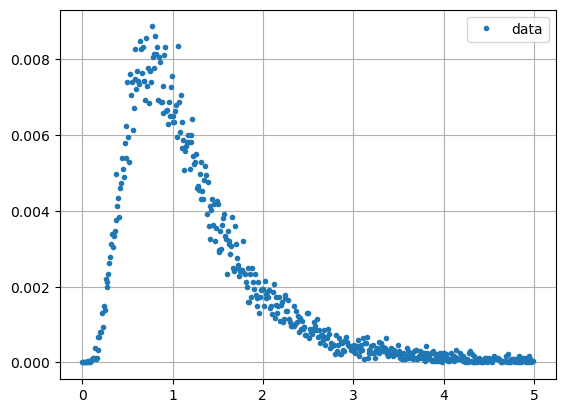

In [5]:
# 1-D Array
ratio_sub_flat = ratio_sub.flatten() 

mean = np.mean(ratio_sub_flat)
variance = np.var(ratio_sub_flat)
y,x = np.histogram(ratio_sub_flat, bins = 500, range=(0,5)) # result = tuple

y = y / np.sum(y) # normalize
x = x[:-1]

plt.grid()
plt.plot(x, y, '.', label='data')
plt.legend()
plt.show()


#### Histogram Matching with F-dist

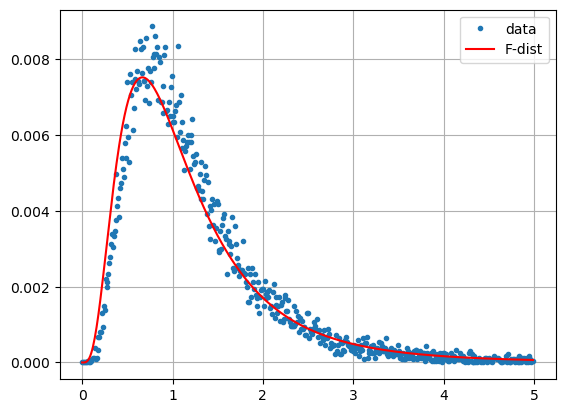

In [6]:

m = 5.0
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()



#### Checking Mean and Variance

In [7]:
print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

1.2473589 1.25
0.67747796 0.9375


#### Ratio Image using single pol


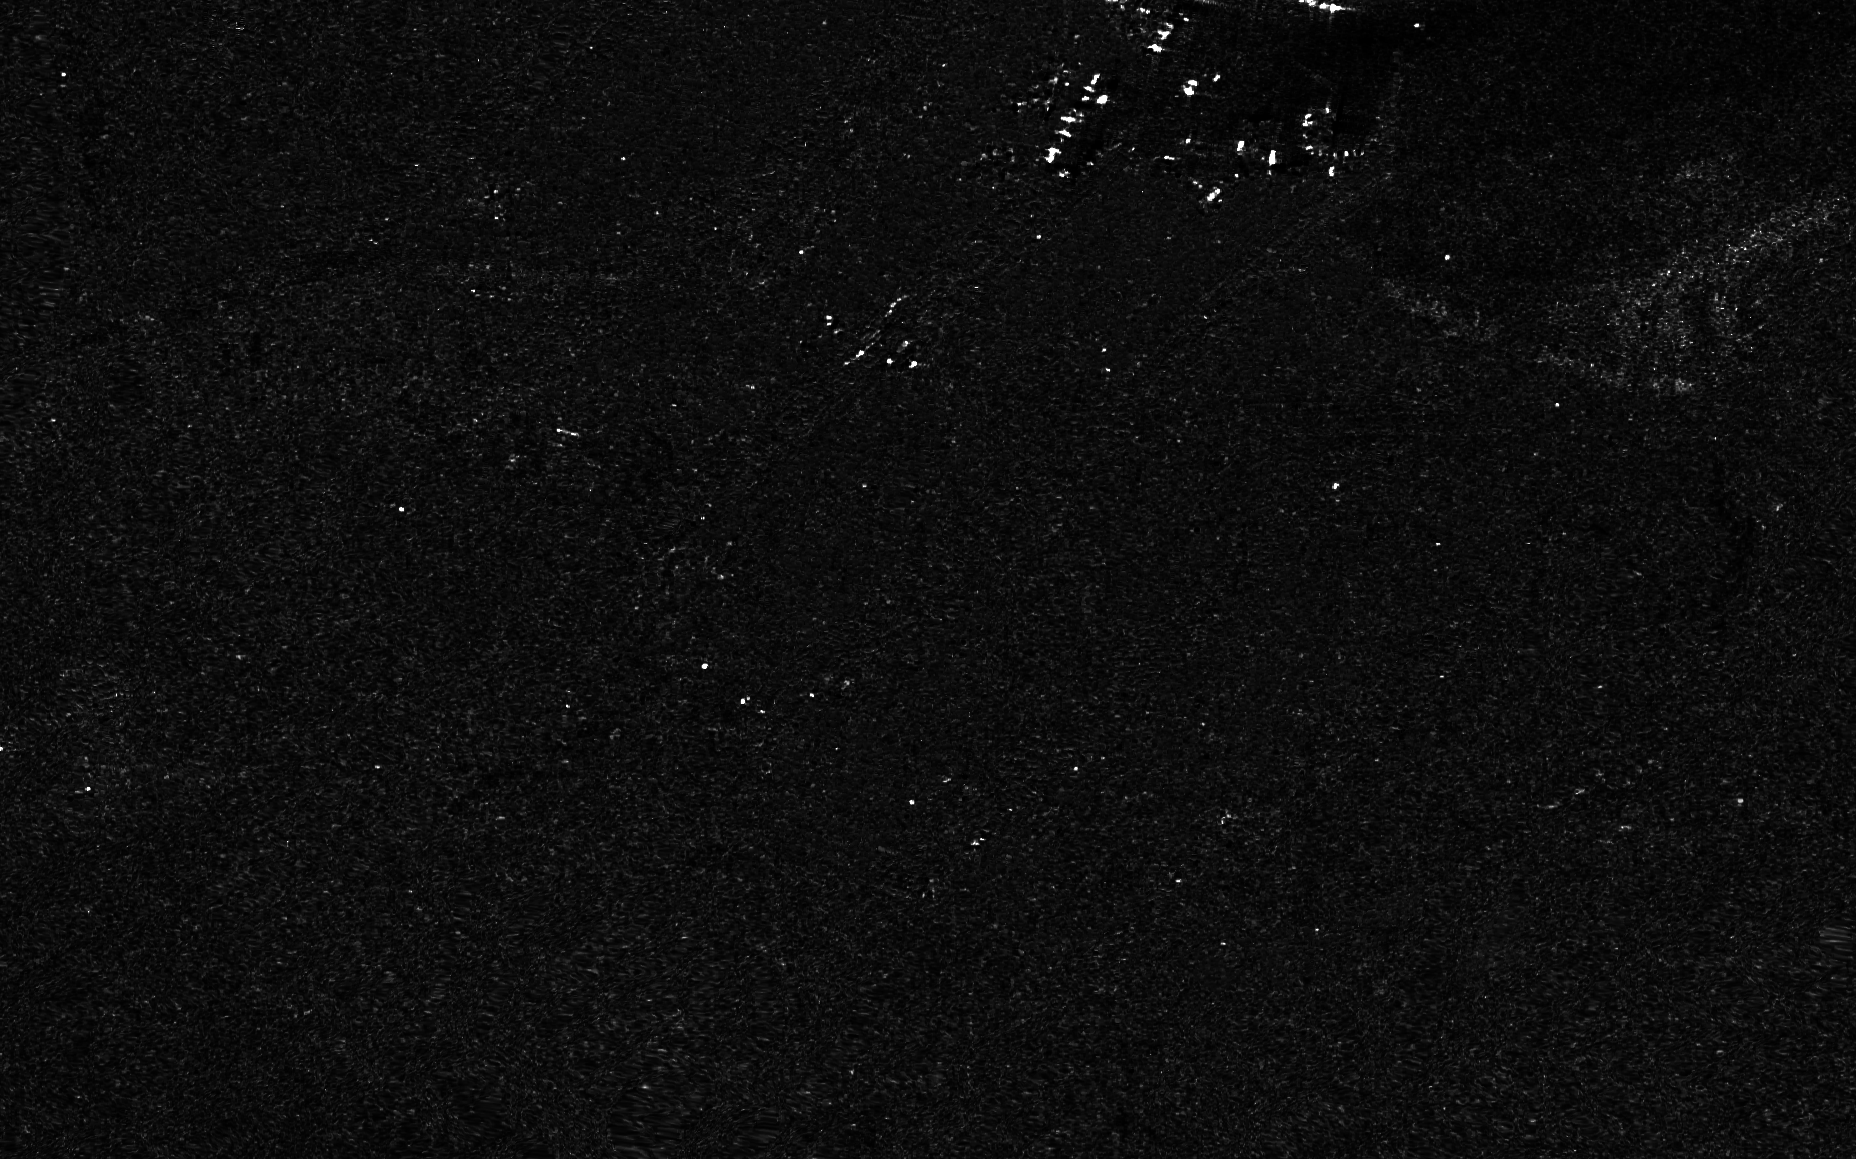

In [15]:

ratio = np.divide(im_list[0]['band_data']['vv_band'],
                  im_list[1]['band_data']['vv_band'])

def ratio_colormap(x):
    # Normalize ratio values between 0 and 20
    ratio_min, ratio_max = 0, 20
    normalized_x = min(max(x, ratio_min), ratio_max) / (ratio_max - ratio_min)
    
    # Map values to black and white color
    color = (normalized_x, normalized_x, normalized_x, 1)
    return color

bounds, location = cd.folium_transform(im_list)

mp = folium.Map(location=location, zoom_start=12)
mp.add_child(folium.raster_layers.ImageOverlay(ratio, bounds=bounds, colormap=ratio_colormap,
                                               opacity=0.8, name = 'Ratio'))
mp.add_child(folium.LayerControl())
#mp.save(r'A:/PYTHON/ChangeDetection/CDT/hyyou/Folium/Ratio Image.html')
display(mp)


#### Direction of Change using single pol


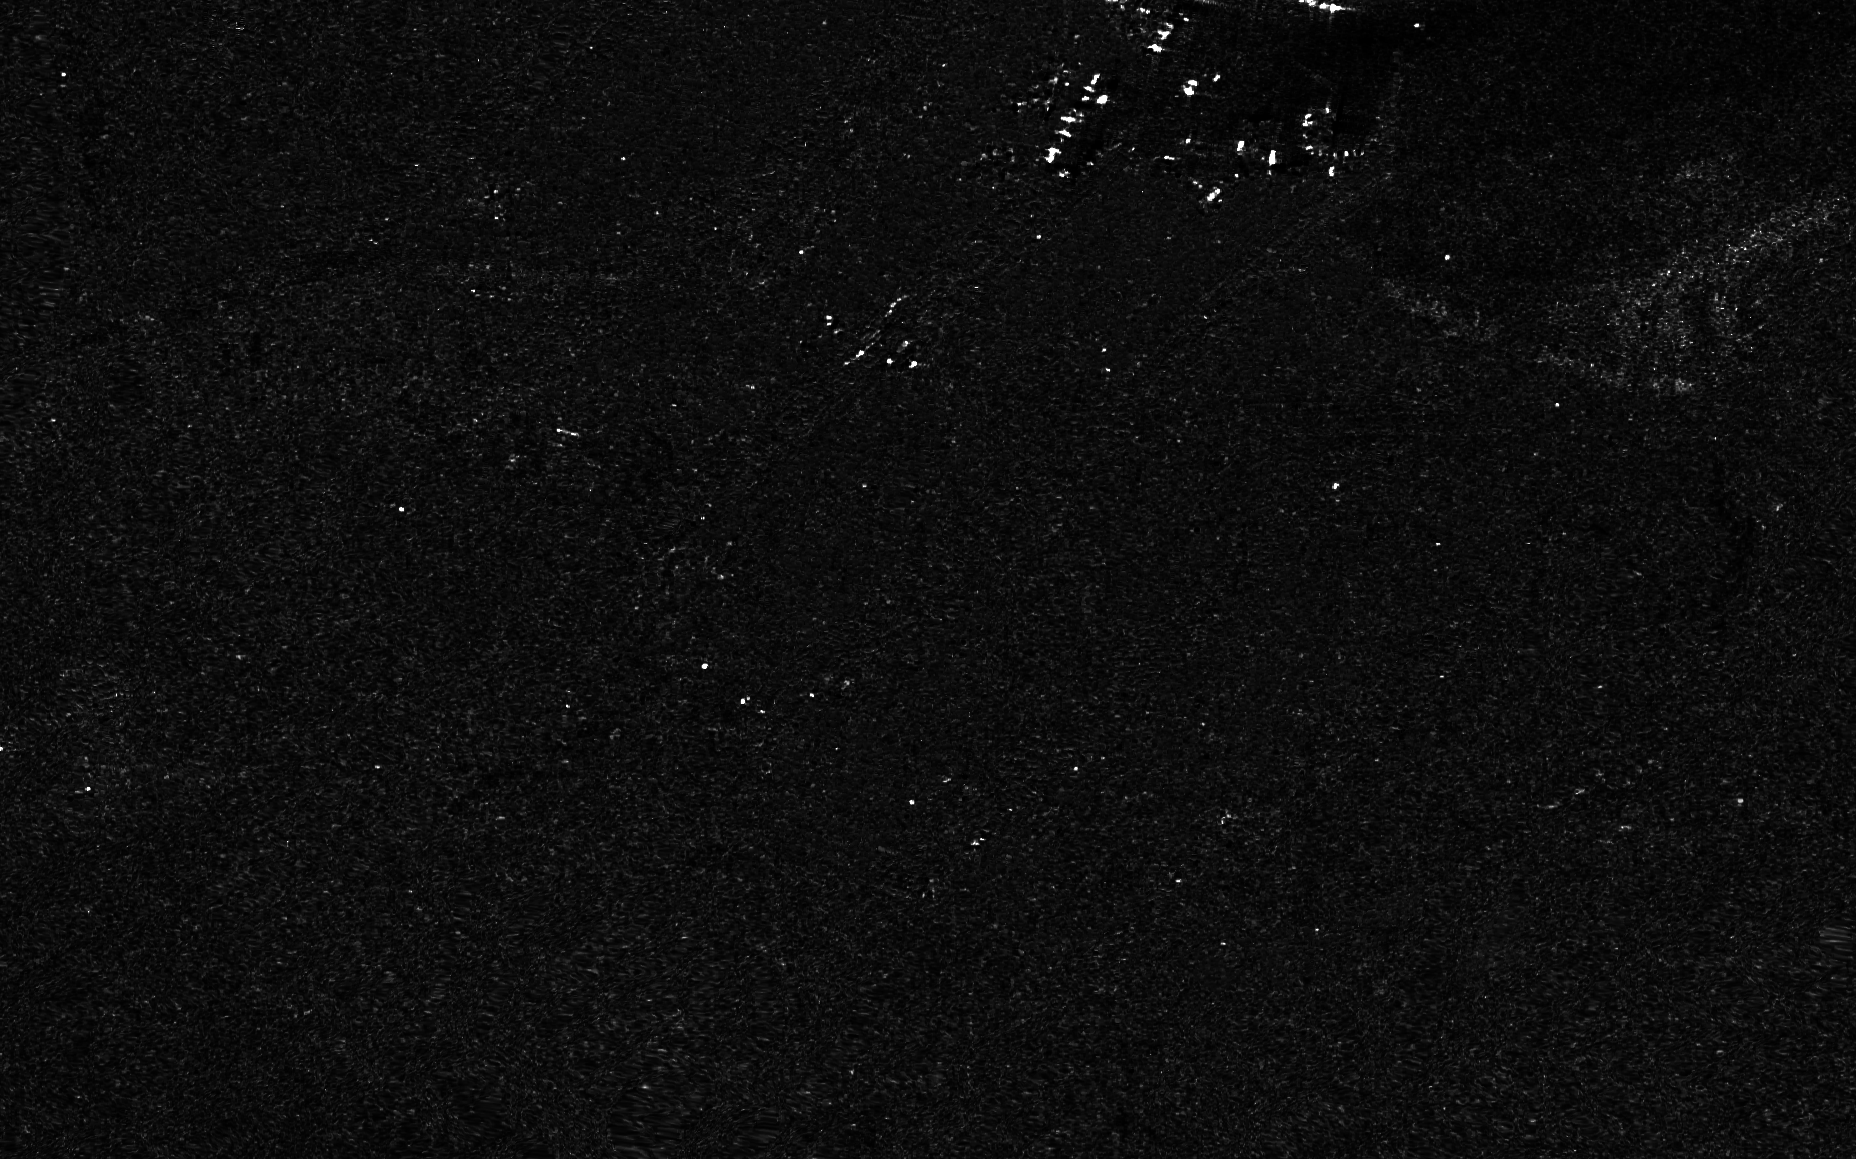
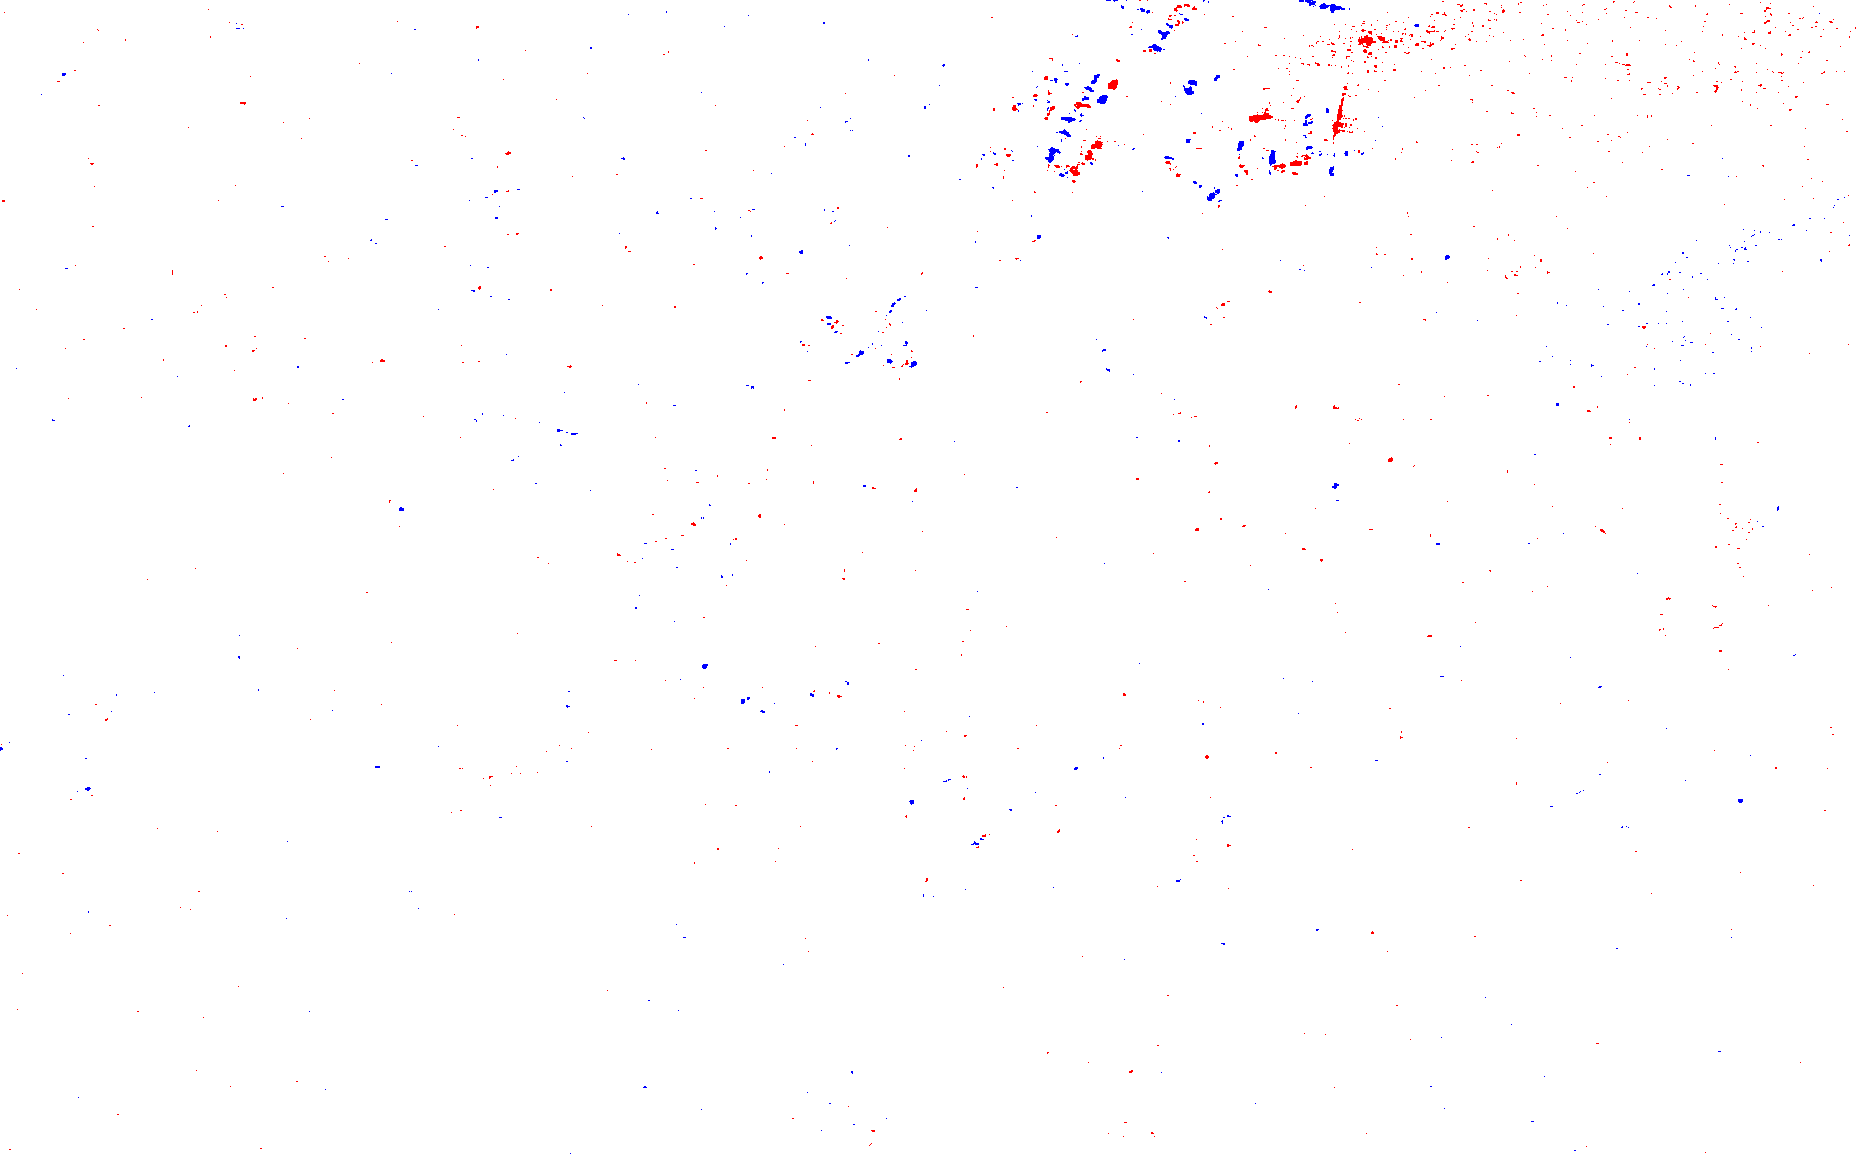

In [17]:

# Decision Threshold
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = np.divide(im_list[0]['band_data']['vv_band'], im_list[1]['band_data']['vv_band'])
q2 = np.divide(im_list[1]['band_data']['vv_band'], im_list[0]['band_data']['vv_band'])

# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = np.zeros_like(im_list[0]['band_data']['vv_band'])
c_map[q2 < dt] = 1
c_map[q1 < dt] = 2

# Mask no-change pixels.
c_map = np.ma.masked_array(c_map, mask=(c_map == 0))
c_map = c_map.astype(int)

colors = ['black', 'blue', 'red']
cmap = ListedColormap(colors)
c_map = cmap(c_map)

mp = folium.Map(location=location, tiles='Stamen Toner', zoom_start=12)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_child(folium.raster_layers.ImageOverlay(ratio, bounds=bounds,
                                               opacity=1, colormap=ratio_colormap,
                                               name = 'Ratio_map'))
mp.add_child(folium.raster_layers.ImageOverlay(c_map, bounds=bounds,
                                               opacity=0.7, name='Change Map'))
mp.add_child(folium.LayerControl())
#mp.save(r'A:/PYTHON/ChangeDetection/CDT/hyyou/Folium/Change Map2.html')
display(mp)


#### Change detection using dual pol
- $$P = {\rm Prob}(-2\log{Q} \ge -2\log{q}) = 1 - {\rm Prob}(-2\log{Q} < -2\log{q}).$$

In [10]:
im_sum = {'band_data': {}}
for band in ['vv_band','vh_band']:
    im_sum['band_data'][band] = im_list[0]['band_data'][band] + im_list[1]['band_data'][band]

# number of looks
m = 5
m2logQ = (np.log(cd.det(im_list[0])) 
        + np.log(cd.det(im_list[1])) 
        - 2 * np.log(cd.det(im_sum)) + 4 * np.log(2)) * (-2 * m)


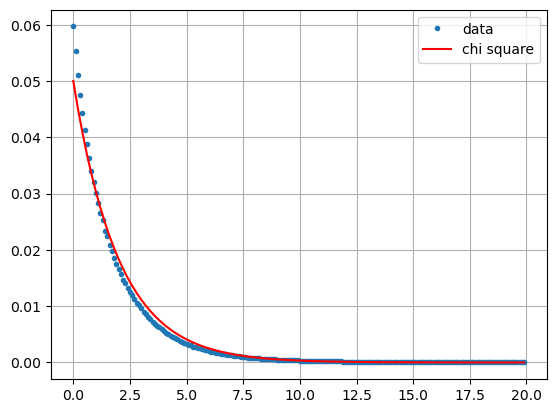

In [11]:

m2logQ_flat = m2logQ.flatten()
y,x = np.histogram(m2logQ_flat, bins = 200, range=(0,20)) # result = tuple

y = y / np.sum(y) # normalize
x = x[:-1]

plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, 2)/10, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()
